In [1]:
import pandas as pd
import numpy as np
import os
import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [83]:
plt.style.use('seaborn-whitegrid')

In [2]:
from base_class import Features, RiskFactors, Universe
from base_func import *

### Load Data inside

In [3]:
# Some Global Variables
CUTOFF_DT = '2015-01-01'
COST = 0.0001

In [4]:
RF = RiskFactors()
factors = {k: RF.get_factor(k) for k in RF.dat.columns[2:]}

udl = Universe()
whole_univ = udl.trade_univ

feats = Features()
feats.try_pivot()

 -- potential issue when processing ds3 -- 
 -- potential issue when processing ds4 -- 
 -- potential issue when processing ds9 -- 
 -- issue when processing ds9 -- 


In [5]:
ret1 = udl.ret_1d

Text(0.5, 1.0, 'Number of active stocks in universe')

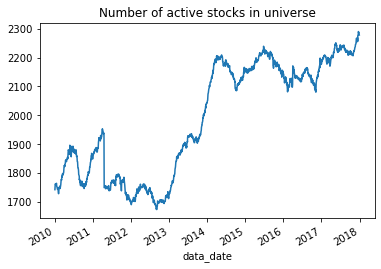

In [6]:
univ = (whole_univ == 'Y').astype(float)
univ.sum(1).plot()
plt.title('Number of active stocks in universe')

Text(0.5, 1.0, 'ds8')

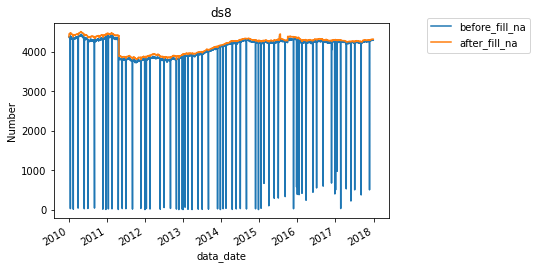

In [7]:
feats.pivot_dat['ds8'].count(1).plot(label='before_fill_na')
feats.pivot_dat['ds8'].fillna(method='ffill', limit=2).count(1).plot(label='after_fill_na')
plt.ylabel('Number')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('ds8')

In [8]:
def convert_constGMV(sig):
    val_sig = xs_normalize(sig).copy()
    val_sig = val_sig.div(val_sig.abs().sum(1), axis=0)
    return val_sig

#### Signal from Data_set_8

Based on my observation, the feature in data_set_8 has similar magnitude compared with volume provided.

Text(0.5, 1.0, 'Distribution of normalized d8 with volume')

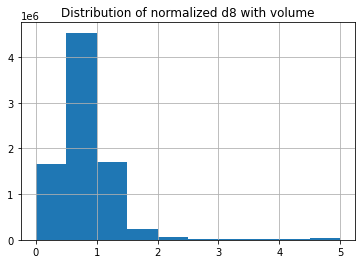

In [9]:
ds8 = feats.pivot_dat['ds8'].fillna(method='ffill', limit=2)
np.clip((ds8 / udl.volume).stack(), 0, 5).hist()
plt.title('Distribution of normalized d8 with volume')

In [10]:
ds8 = feats.pivot_dat['ds8'].fillna(method='ffill', limit=2)
norm_ds8 = np.clip((ds8 / udl.volume), 0, 5)

raw_sig = xs_normalize(norm_ds8[univ == 1]) # tradable universe is assumed known at date t.

In [11]:
resid = factor_residualize(raw_sig.ewm(halflife=10).mean()[univ == 1], 
                             factors.values())

  0%|          | 0/2080 [00:00<?, ?it/s]

In [12]:
def plot_pnl(pl_analysis, cutoff_dt=None):
    if type(pl_analysis) == pd.Series:
        pl_analysis = pd.DataFrame(pl_analysis, columns=['signal'])
    
    cum_ret = pl_analysis.cumsum()
    
    title = 'Cumulative Return'
    ax = cum_ret.plot(title=title, figsize=(16, 4))

    plt.legend(["%s" % (x) + "" for x in pl_analysis.columns])
    if cutoff_dt is not None:
        plt.axvline(pd.to_datetime(cutoff_dt), linestyle='--', c='black')
        ndays = lambda x, y: (pd.to_datetime(y) - pd.to_datetime(x)).days
        x_min, x_max = ax.get_xlim()
        x_min = matplotlib.dates.num2date(x_min).date()
        x_max = matplotlib.dates.num2date(x_max).date()
        pos = ndays(x_min, cutoff_dt) / ndays(x_min, x_max)
        plt.text(pos - 0.03, 0.95, 'IS', ha='center', va='center', transform=ax.transAxes, fontsize=12)
        plt.text(pos + 0.03, 0.95, 'OOS', ha='center', va='center', transform=ax.transAxes, fontsize=12)
        
    plt.show()
    
    ann_rets = pl_analysis.resample('A').sum()
    period = 'Annual'
    ann_rets.index = [x.year for x in ann_rets.index]
    ann_rets.plot.bar(title=f'{period} Returns', figsize=(16, 4))
    plt.show()

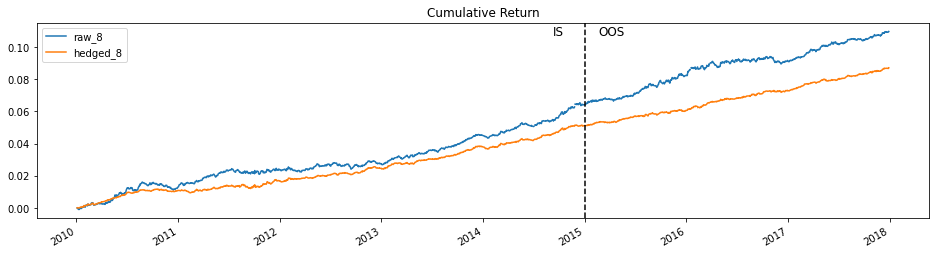

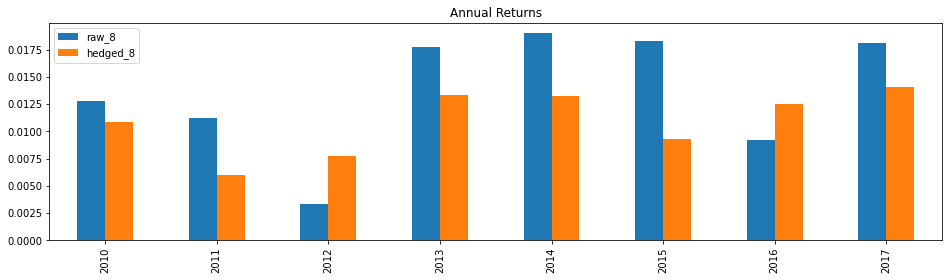

In [13]:
_pnl = {
    'raw_8': (raw_sig.shift(2)[univ == 1].fillna(0) * ret1).mean(1),
    'hedged_8': (resid.shift(2)[univ == 1].fillna(0) * ret1).mean(1),
}

plot_pnl(pd.DataFrame(_pnl), cutoff_dt=CUTOFF_DT)

In [14]:
sigs = {
    'raw_8': raw_sig.shift(2)[univ == 1].fillna(0),
    'hedged_8': resid.shift(2)[univ == 1].fillna(0),
}

stats, cum_ret, pl_analysis = PNL_analysis(sigs, ret1, cutoff_dt=CUTOFF_DT,
                 nDaysYear=252, cost=0, detail_analysis=False)

In [15]:
display_stats(stats) # Before cost

,Sharpe,IS Sharpe,OOS Sharpe,Daily TO(%)
raw_8,2.37,2.36,2.41,39.23
hedged_8,3.43,3.23,3.76,8.76


In [16]:
stats, cum_ret, pl_analysis = PNL_analysis(sigs, ret1, cutoff_dt=CUTOFF_DT,
                 nDaysYear=252, cost=COST, detail_analysis=False)

display_stats(stats) # After cost

,Sharpe,IS Sharpe,OOS Sharpe,Daily TO(%)
raw_8,1.53,1.58,1.46,39.23
hedged_8,3.22,3.03,3.54,8.76


In [17]:
def get_distribution(df, title=None):
    extrems = df.stack().quantile([0.01, 0.05, 0.95, 0.99])
    low_ = (extrems.loc[0.01] + extrems.loc[0.05]) // 2
    low_ = low_ - 1 if low_ < 0 else low_
    high_ = (extrems.loc[0.95] + extrems.loc[0.99]) // 2
    
    gap = (high_ - low_) / 20
    # Plot hist distribution
    plt.figure()
    np.clip(df.stack(), low_, high_).hist(bins=np.arange(low_, high_ + gap, gap))
    plt.title(title) if title is not None else plt.title('distribution')
    plt.show()
    
    return low_, high_

- ds10 and ds11 focus on the same data type

<AxesSubplot:xlabel='data_date'>

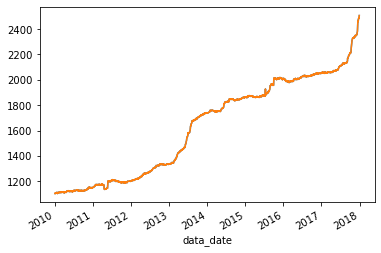

In [18]:
ds10 = feats.pivot_dat['ds10'].copy()
ds11 = feats.pivot_dat['ds11'].copy()

ds10.count(1).plot()
ds11.count(1).plot()

Text(0.5, 1.0, 'CrossSectional correlation between ds10 and ds11')

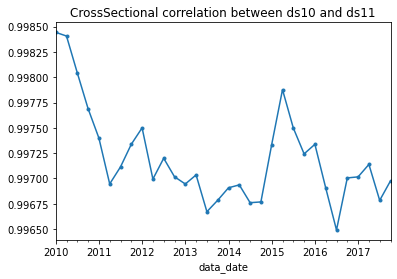

In [19]:
xs_corr = ds10.T.corrwith(ds11.T)
xs_corr.resample('Q').mean().plot(marker='.')
plt.title('CrossSectional correlation between ds10 and ds11')

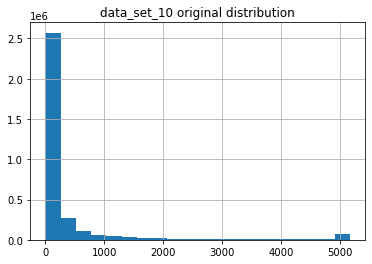

(1.0, 5164.0)

In [20]:
get_distribution(ds10, title='data_set_10 original distribution')

Text(0.5, 1.0, 'Distribution of log10(1 + ds10)')

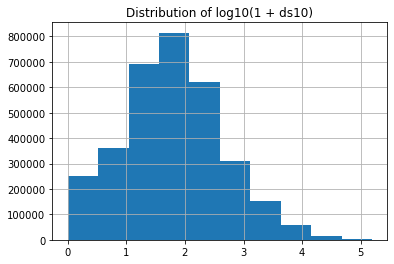

In [21]:
np.log10(1+ds10).stack().hist()
plt.title('Distribution of log10(1 + ds10)')

In [22]:
raw10 = xs_standardize(np.log10(1 + ds10))
resid_10 = factor_residualize(raw10, factors.values())

  0%|          | 0/2013 [00:00<?, ?it/s]

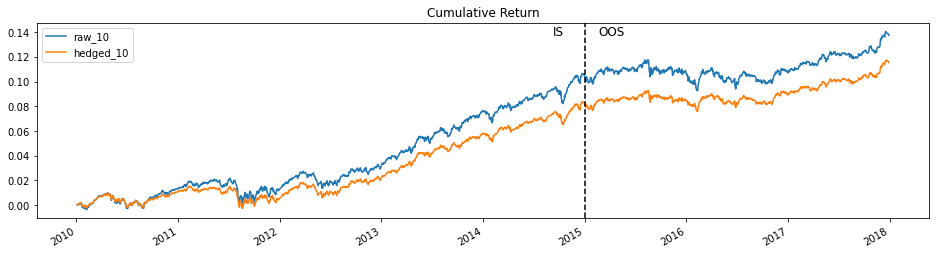

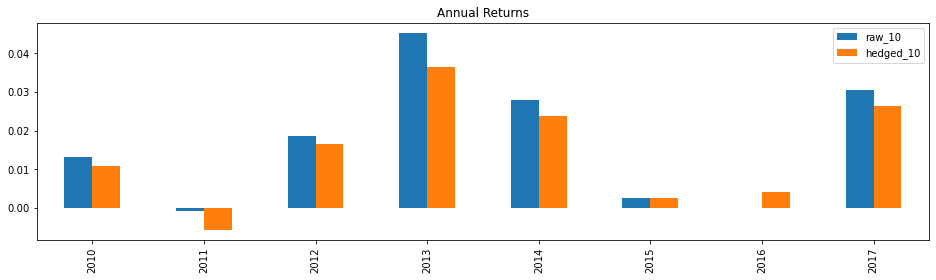

In [23]:
_pnl = {
    'raw_10': (raw10.shift(2)[univ == 1].fillna(0) * ret1).mean(1),
    'hedged_10': (resid_10.shift(2)[univ == 1].fillna(0) * ret1).mean(1),
}

plot_pnl(pd.DataFrame(_pnl), cutoff_dt=CUTOFF_DT)

In [24]:
sigs = {
    'raw_8': raw_sig.shift(2)[univ == 1].fillna(0),
    'hedged_8': resid.shift(2)[univ == 1].fillna(0),
    'raw10': raw10.shift(2)[univ == 1].fillna(0),
    'hedged10': resid_10.shift(2)[univ == 1].fillna(0),
}

stats, cum_ret, pl_analysis = PNL_analysis(sigs, ret1, cutoff_dt=CUTOFF_DT,
                 nDaysYear=252, cost=0, detail_analysis=False)
display_stats(stats)

,Sharpe,IS Sharpe,OOS Sharpe,Daily TO(%)
raw_8,2.37,2.36,2.41,39.23
hedged_8,3.43,3.23,3.76,8.76
raw10,0.97,1.29,0.58,1.36
hedged10,1.09,1.28,0.81,1.69


Text(0.5, 1.0, 'Cross-sectional correlation between hedged signal 8 and signal 10')

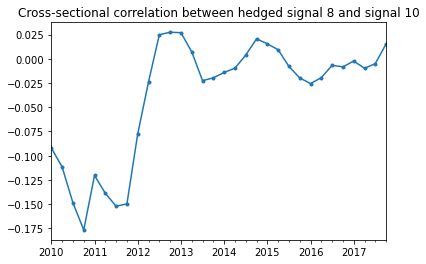

In [25]:
sigs['hedged_8'].T.corrwith(sigs['hedged10'].T).resample('Q').mean().plot(marker='.')
plt.title('Cross-sectional correlation between hedged signal 8 and signal 10')

In [26]:
def plot_heatmap(corr_df, cur_title='heatmap plot'):
    plt.figure(figsize=(8, 5))
    for i in range(corr_df.shape[0]):
        corr_df.iloc[i, i] = np.nan
    
    sns.heatmap(corr_df)
    plt.title(cur_title)
    plt.show()

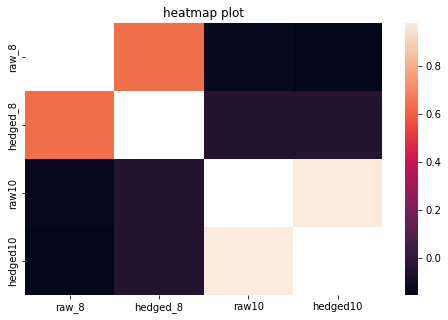

In [27]:
plot_heatmap(pl_analysis.corr())

In [28]:
resid_10over11 = factor_residualize(ds10, [ds11], add_constant=True)

  0%|          | 0/2013 [00:00<?, ?it/s]

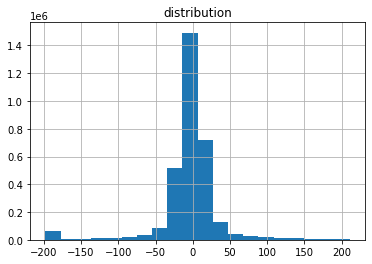

(-198.0, 211.0)

In [29]:
get_distribution(resid_10over11)

- From Data_set_1 to Data_set_7, they are all very sparse signals which focus on events similar to Earning Announcements

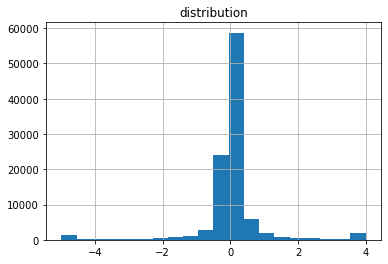

In [30]:
ds6 = feats.pivot_dat['ds6'].copy()
low_6, high_6 = get_distribution(ds6)

In [31]:
_df = ds6[univ == 1].stack().reset_index()
_df['year'] = _df.data_date.apply(lambda x: x.year)
_df.groupby('year')[0].agg(['mean', 'median'])

,mean,median
year,,
2010,0.131451,0.00670
2011,0.133133,0.05040
2012,0.082659,0.05740
2013,0.138383,0.04620
2014,0.052105,0.04020
2015,0.802769,0.04050
2016,0.250665,0.01645
2017,1.596543,0.01640


In [33]:
# Try to set up dynamic threshold
cur_thres = 0
df_ls = []
for year in tqdm(range(2010, 2018)):
    cur_df = _df[_df.year == year].copy()
    cur_df['value'] = cur_df[0].apply(lambda x: 1 if x >= cur_thres else -1)
    df_ls.append(cur_df.copy())
    cur_thres = cur_df[0].median()
    
tmp_df = pd.concat(df_ls)

/var/folders/7f/ycjyh04128z7pkjg6fbv8kbh0000gn/T/ipykernel_2907/2960424181.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for year in tqdm(range(2010, 2018)):


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1849 [00:00<?, ?it/s]

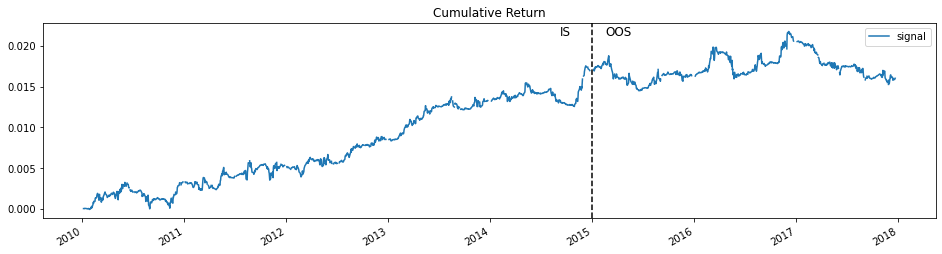

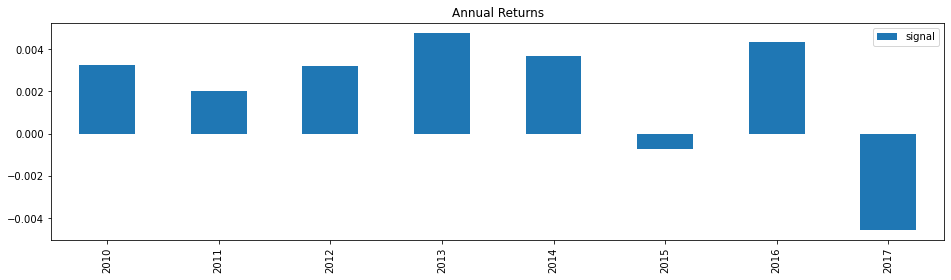

In [34]:
raw_sig6 = tmp_df.pivot(index='data_date', columns='security_id', 
                        values='value').fillna(method='ffill', limit=20)
resid6_ = factor_residualize(raw_sig6, factors.values())
# norm_6 = raw_sig6[univ == 1] / 1000
plot_pnl((-resid6_.shift(2)[univ == 1].fillna(0) * ret1).mean(1), cutoff_dt=CUTOFF_DT)

In [35]:
val_sig = xs_normalize(raw_sig6).copy()
val_sig = val_sig.div(val_sig.abs().sum(1), axis=0)
resid_sign = factor_residualize(val_sig, factors.values())

  0%|          | 0/1849 [00:00<?, ?it/s]

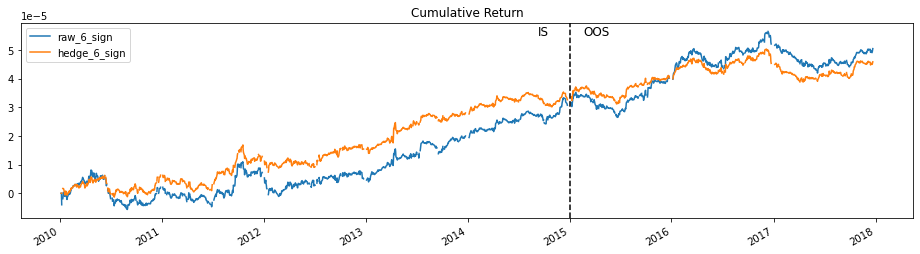

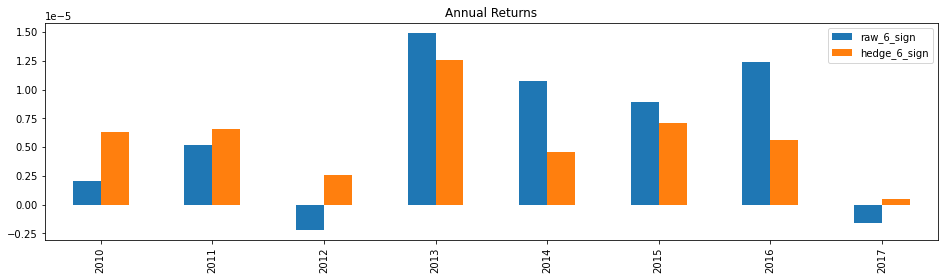

In [36]:
_pnl6 = {
    'raw_6_sign': (-val_sig.shift(2)[univ == 1].fillna(0) * ret1).mean(1),
    'hedge_6_sign': (-resid_sign.shift(2)[univ == 1].fillna(0) * ret1).mean(1),
}
plot_pnl(pd.DataFrame(_pnl6), cutoff_dt=CUTOFF_DT)

In [37]:
sigs = {
    'raw_6_sign': -val_sig.shift(2)[univ == 1].fillna(0),
    'hedge_6_sign': -resid_sign.shift(2)[univ == 1].fillna(0),
}

stats, cum_ret, pl_analysis = PNL_analysis(sigs, ret1, cutoff_dt=CUTOFF_DT,
                 nDaysYear=252, cost=0, detail_analysis=False)
display_stats(stats)

,Sharpe,IS Sharpe,OOS Sharpe,Daily TO(%)
raw_6_sign,0.77,0.73,0.84,10.59
hedge_6_sign,0.82,0.89,0.70,11.11


In [38]:
df_ls = []
for num in range(1, 8):
    df_ls.append(feats.raw_dfs[f'ds{num}'].drop_duplicates().set_index(['data_date', 'security_id']).copy())

In [39]:
total_df = pd.concat(df_ls, axis=1)

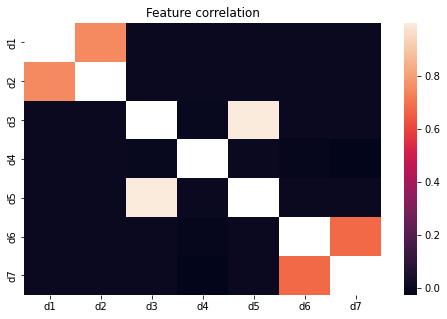

In [40]:
corr_ = total_df.dropna(axis=0).corr()
plot_heatmap(corr_, cur_title='Feature correlation')

In [41]:
corr_

,d1,d2,d3,d4,d5,d6,d7
d1,NaN,0.747951,-0.000020,0.003764,-0.000008,-0.000124,-0.000195
d2,0.747951,NaN,-0.000022,0.004955,-0.000016,-0.000158,-0.000245
d3,-0.000020,-0.000022,NaN,-0.001740,0.998462,-0.000424,-0.000036
d4,0.003764,0.004955,-0.001740,NaN,-0.000832,-0.013032,-0.025506
d5,-0.000008,-0.000016,0.998462,-0.000832,NaN,-0.000593,-0.000102
d6,-0.000124,-0.000158,-0.000424,-0.013032,-0.000593,NaN,0.676477
d7,-0.000195,-0.000245,-0.000036,-0.025506,-0.000102,0.676477,NaN


In [42]:
df_ = total_df.dropna(axis=0)
df_.head(2)

d1       d2        d3       d4        d5      d6  \
data_date  security_id                                                         
2010-01-04 647001       3.4530   3.9360  0.079633   5.9847  0.037713 -0.0660   
           2486001     -4.0556 -15.6589 -0.350052 -14.8978 -0.084879 -0.4623   

                           d7  
data_date  security_id         
2010-01-04 647001      -0.174  
           2486001     -1.032

Text(0.5, 1.0, 'Histogram of new generate feature from ds1 and ds2.')

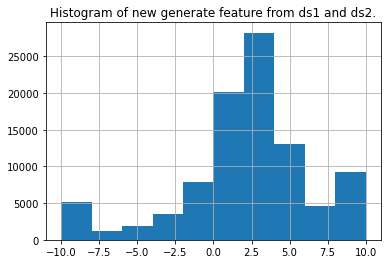

In [43]:
val = np.clip(df_['d2'] / df_['d1'], -10, 10)
val.hist()
plt.title('Histogram of new generate feature from ds1 and ds2.')

In [44]:
df1 = val.reset_index()

<AxesSubplot:xlabel='data_date'>

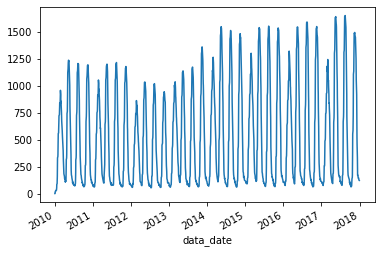

In [45]:
raw1 = df1.pivot(index='data_date', columns='security_id',
                values=0).fillna(method='ffill', limit=20)
raw1[univ == 1].count(1).plot()

In [46]:
resid_1with2 = factor_residualize(np.sign(raw1), factors.values())

  0%|          | 0/1971 [00:00<?, ?it/s]

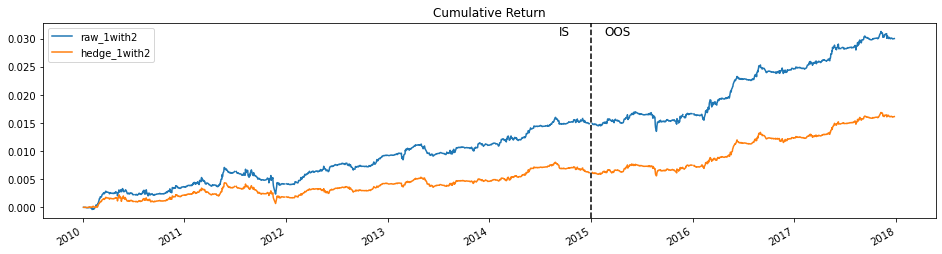

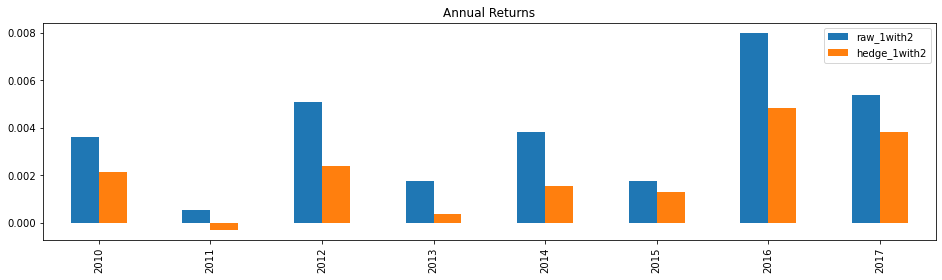

In [47]:
_pnls_1with2 = {
    'raw_1with2': (xs_normalize(np.sign(raw1)).shift(2)[univ == 1].fillna(0) * ret1).mean(1),
    'hedge_1with2': (resid_1with2.shift(2)[univ == 1].fillna(0) * ret1).mean(1),
}

plot_pnl(pd.DataFrame(_pnls_1with2), 
                   cutoff_dt=CUTOFF_DT)

When I tried to apply const GMV on this signal, the overall performance is down

In [48]:
raw_sign1 = xs_normalize(np.sign(raw1))
raw_sign1 = raw_sign1.div(raw_sign1.abs().sum(1), axis=0)
resid_sign1 = factor_residualize(raw_sign1, factors.values())

  0%|          | 0/1971 [00:00<?, ?it/s]

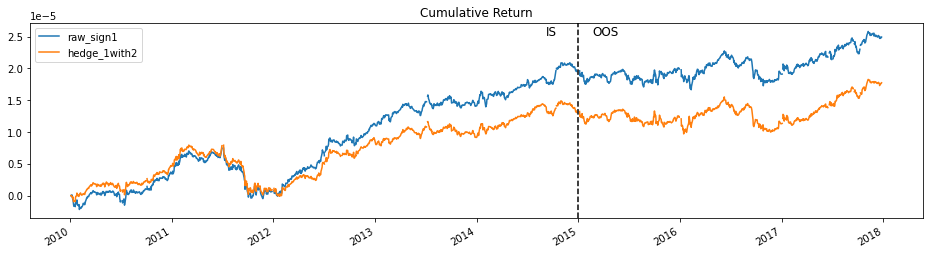

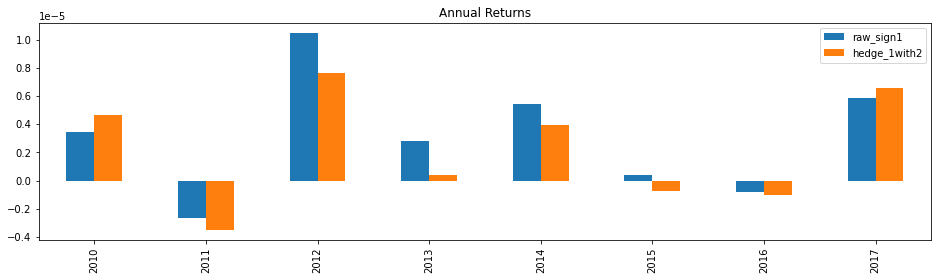

In [49]:
_pnls_1with2_1 = {
    'raw_sign1': (raw_sign1.shift(2)[univ == 1].fillna(0) * ret1).mean(1),
    'hedge_1with2': (resid_sign1.shift(2)[univ == 1].fillna(0) * ret1).mean(1),
}

plot_pnl(pd.DataFrame(_pnls_1with2_1), 
                   cutoff_dt=CUTOFF_DT)

### Portfolio Construction

#### Signal Combination with events datasets.

Set up the assign weight = 0.3 to signal from data_set_6 and 0.7 to signal from data_set_1 and data_set_2.

In [50]:
w = 0.3
mask = (raw_sig6 == raw_sig6) | (np.sign(raw1) == np.sign(raw1))
combined_sign = -raw_sig6.fillna(0) * w + np.sign(raw1).fillna(0) * (1 - w)

In [51]:
val_ = xs_normalize(combined_sign[mask])
val_total = val_.div(val_.abs().sum(1), axis=0)

In [52]:
hedge_total = factor_residualize(val_, factors.values())

  0%|          | 0/1971 [00:00<?, ?it/s]

In [53]:
def signal_convert(signal_dict, cost=0):
    sigs = {k: v.shift(2)[univ == 1].fillna(0) for k, v in signal_dict.items()}
    pnls_ = {k: (v.shift(2)[univ == 1].fillna(0) * ret1).mean(1) for k, v in signal_dict.items()}
    
    plot_pnl(pd.DataFrame(pnls_), cutoff_dt=CUTOFF_DT)
    
    stats, cum_ret, pl_analysis = PNL_analysis(sigs, ret1, cutoff_dt=CUTOFF_DT,
                 nDaysYear=252, cost=cost, detail_analysis=False)
    return stats

In [54]:
sigevent_dict = {'raw_eventSig': val_,
             'hedge_eventSig': hedge_total, 
             }

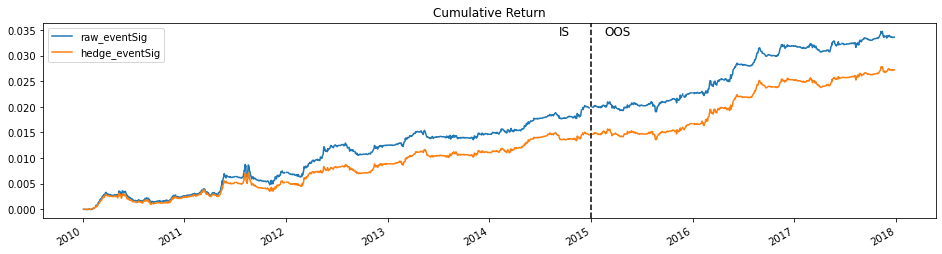

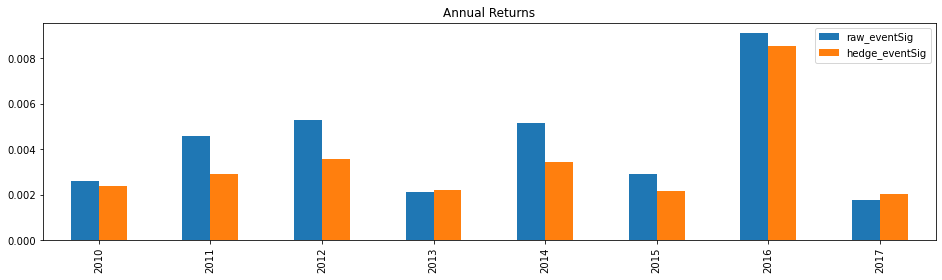

In [55]:
stats = signal_convert(sigevent_dict, cost=0)

In [56]:
display_stats(stats)

,Sharpe,IS Sharpe,OOS Sharpe,Daily TO(%)
raw_eventSig,1.49,1.42,1.60,9.16
hedge_eventSig,1.41,1.23,1.68,9.81


In [57]:
hedge_ = factor_residualize(val_total, factors.values())

  0%|          | 0/1971 [00:00<?, ?it/s]

In [58]:
sigs = {
    'hedge_eventSig_constGMV': hedge_total.div(hedge_total.abs().sum(1), axis=0).shift(2)[univ == 1],
    'hedge_': hedge_.div(hedge_.abs().sum(1), axis=0).shift(2)[univ == 1],
}

In [59]:
stats, cum_ret, pl_analysis = PNL_analysis(sigs, ret1, cutoff_dt=CUTOFF_DT,
                 nDaysYear=252, cost=0, detail_analysis=False)
display_stats(stats)

,Sharpe,IS Sharpe,OOS Sharpe,Daily TO(%)
hedge_eventSig_constGMV,0.87,0.80,0.99,17.44
hedge_,0.90,0.85,0.99,17.43


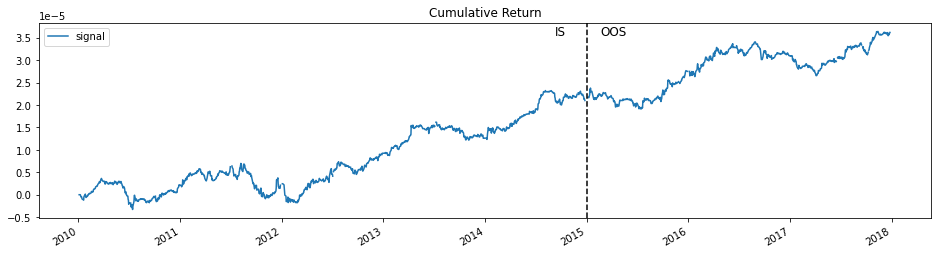

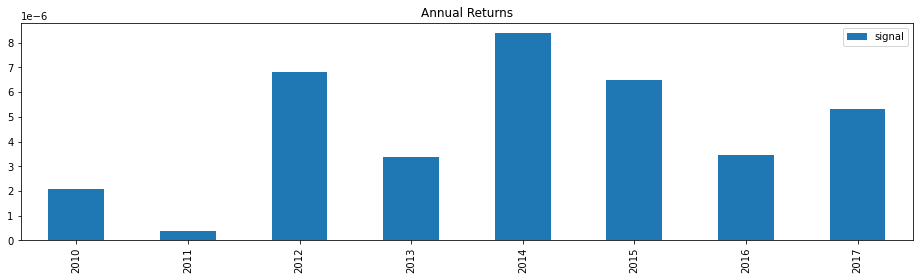

In [60]:
# hedge_potfolio = hedge_total.div(hedge_total.abs().sum(1), axis=0) * 2
plot_pnl((hedge_.shift(2)[univ == 1].fillna(0) * ret1).mean(1), 
                  cutoff_dt=CUTOFF_DT)

In [61]:
def long_short_construct(combined_sig):
    long_part = combined_sig[combined_sig > 0]
    long_part = long_part.div(long_part.abs().sum(1), axis=0)
    short_part = combined_sig[combined_sig <= 0]
    short_part = short_part.div(short_part.abs().sum(1), axis=0)
    position = short_part.fillna(0) + long_part.fillna(0)
    return position

#### Baseline Construction

In [62]:
# Taking the hedged residuals to construct portfolio.
portfolio_8 = long_short_construct(resid[univ == 1])

In [63]:
all_portfolio = {
    'portfolio_8': portfolio_8.shift(2)[univ == 1].fillna(0),
}

stats, cum_ret, DrawDown_res = PNL_analysis(all_portfolio, 
                                            ret1, cutoff_dt=CUTOFF_DT,
                 nDaysYear=252, cost=COST, nlargest_DD=1, detail_analysis=True)

In [64]:
display_stats(stats)

,Sharpe,IS Sharpe,OOS Sharpe,Daily TO(%),annualized_returns(%),annualized_volatility(%),positive_dates(%)
portfolio_8,3.27,3.1,3.54,8.74,11.24,3.44,56.23


In [65]:
DrawDown_res['portfolio_8'].rename(columns={'portfolio_8': 'cummulative_pnl'})

,data_date,cummulative_pnl,cummax,DD_from_dt,DrawDown,DD_pct(%)
0,2011-02-15,0.101748,0.132219,2010-10-20,-0.03047,-23.05


Text(0.5, 1.0, 'Cumulative Returns of Baseline Model from ds8')

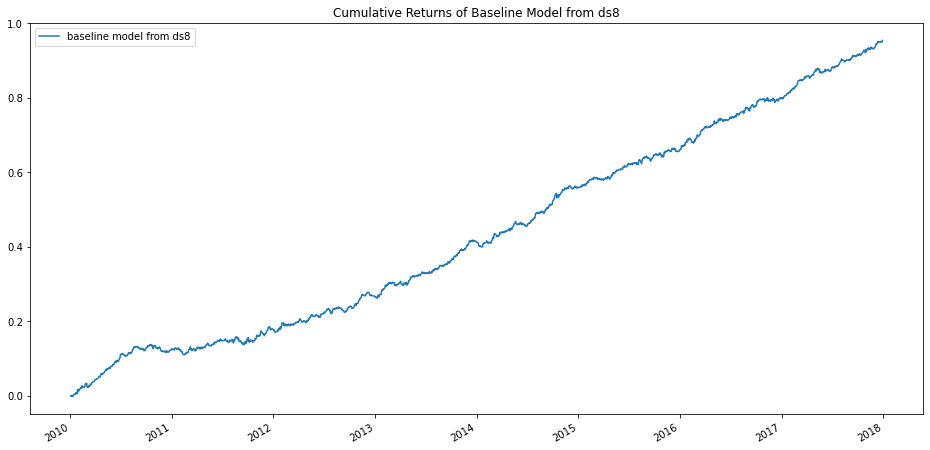

In [66]:
plt.figure(figsize=(16, 8))
(portfolio_8.shift(2)[univ == 1].fillna(0) * ret1).sum(1).cumsum().plot(label='baseline model from ds8')
plt.legend()
# plt.grid()
plt.title('Cumulative Returns of Baseline Model from ds8')

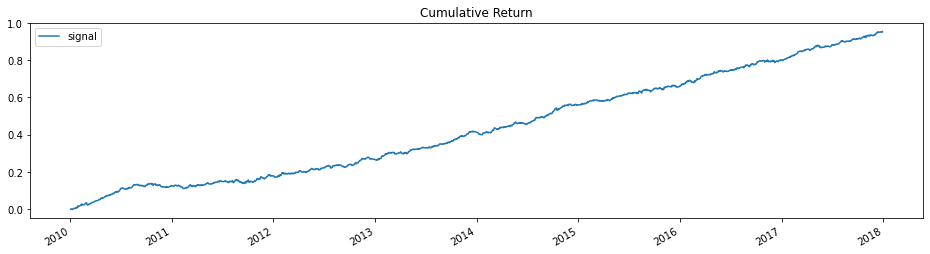

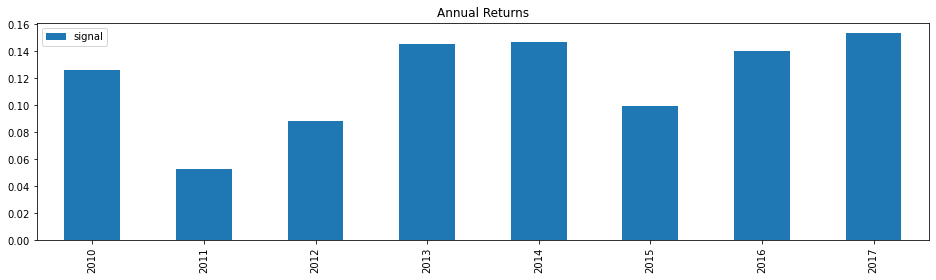

In [67]:
plot_pnl((portfolio_8.shift(2)[univ == 1].fillna(0) * ret1).sum(1))

In [68]:
w = 0.9
sig1 = const_gmv(raw_sig.ewm(halflife=10).mean()) # raw_sig.ewm(halflife=10).mean()
sig2 = const_gmv(raw10.copy())
mask = (sig1 == sig1) | (sig2 == sig2)
signal = (sig1.fillna(0) * w + sig2.fillna(0) * (1 - w))[mask]

In [69]:
resid_8_10 = factor_residualize(signal.ewm(halflife=10).mean(), factors.values())

  0%|          | 0/2080 [00:00<?, ?it/s]

In [70]:
portfolio_8_10 = long_short_construct(resid_8_10[univ == 1])

In [71]:
all_portfolio = {
    'portfolio_8': portfolio_8.shift(2)[univ == 1].fillna(0),
    'portfolio_8/10': portfolio_8_10.shift(2)[univ == 1].fillna(0),
}
stats, cum_ret, DrawDown_res = PNL_analysis(all_portfolio, 
                                            ret1, cutoff_dt=CUTOFF_DT,
                 nDaysYear=252, cost=COST, nlargest_DD=1, detail_analysis=True)
display_stats(stats)

,Sharpe,IS Sharpe,OOS Sharpe,Daily TO(%),annualized_returns(%),annualized_volatility(%),positive_dates(%)
portfolio_8,3.27,3.10,3.54,8.74,11.24,3.44,56.23
portfolio_8/10,2.59,2.48,2.78,6.76,10.46,4.04,53.80


In [72]:
show_drawdown(DrawDown_res)

,data_date,cummulative_pnl,cummax,DD_from_dt,DrawDown,DD_pct(%)
portfolio_8,2011-02-15,0.101748,0.132219,2010-10-20,-0.030470,-23.05
portfolio_8/10,2013-01-09,0.277656,0.307361,2012-12-04,-0.029705,-9.66


Text(0.5, 1.0, 'Cumulative Returns of Baseline Model from ds8')

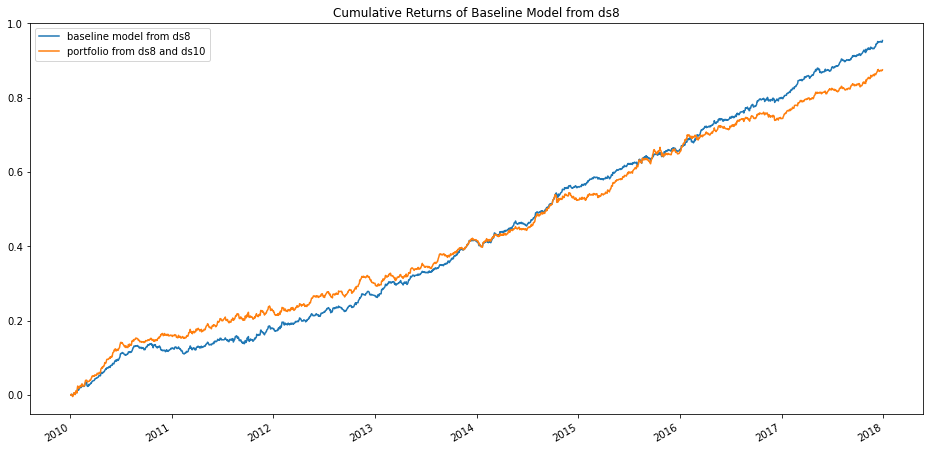

In [73]:
plt.figure(figsize=(16, 8))
(portfolio_8.shift(2)[univ == 1].fillna(0) * ret1).sum(1).cumsum().plot(label='baseline model from ds8')
(portfolio_8_10.shift(2)[univ == 1].fillna(0) * ret1).sum(1).cumsum().plot(label='portfolio from ds8 and ds10')
plt.legend()
# plt.grid()
plt.title('Cumulative Returns of Baseline Model from ds8')

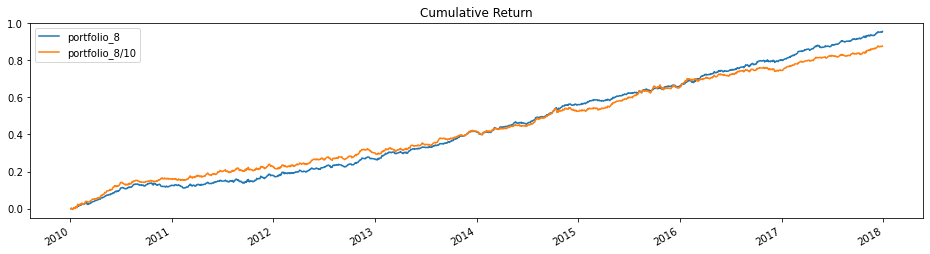

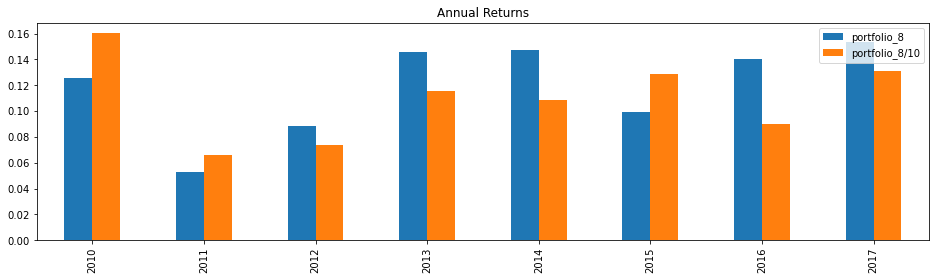

In [74]:
plot_pnl(pd.DataFrame({k: (v * ret1).sum(1)  for k, v in all_portfolio.items()}))

In [75]:
event_portfolio = long_short_construct(hedge_total)

In [76]:
new_portfolio = long_short_construct(portfolio_8_10.copy().fillna(0) + event_portfolio.fillna(0) * 0.1)
# hedged_portfolio = factor_residualize(new_portfolio, factors.values())

In [77]:
all_portfolio = {
    'portfolio_8': portfolio_8.shift(2)[univ == 1].fillna(0),
    'portfolio_8/10': portfolio_8_10.shift(2)[univ == 1].fillna(0),
    'final_portfolio': new_portfolio.shift(2)[univ == 1].fillna(0),
#     'final_hedge': hedged_portfolio.shift(2)[univ == 1].fillna(0),
}

In [78]:
stats, cum_ret, DrawDown_res = PNL_analysis(all_portfolio, 
                                            ret1, cutoff_dt=CUTOFF_DT,
                 nDaysYear=252, cost=COST, nlargest_DD=1, detail_analysis=True)
display_stats(stats)

,Sharpe,IS Sharpe,OOS Sharpe,Daily TO(%),annualized_returns(%),annualized_volatility(%),positive_dates(%)
portfolio_8,3.27,3.10,3.54,8.74,11.24,3.44,56.23
portfolio_8/10,2.59,2.48,2.78,6.76,10.46,4.04,53.80
final_portfolio,2.55,2.59,2.48,8.86,10.38,4.07,52.76


In [79]:
show_drawdown(DrawDown_res)

,data_date,cummulative_pnl,cummax,DD_from_dt,DrawDown,DD_pct(%)
portfolio_8,2011-02-15,0.101748,0.132219,2010-10-20,-0.030470,-23.05
portfolio_8/10,2013-01-09,0.277656,0.307361,2012-12-04,-0.029705,-9.66
final_portfolio,2015-01-27,0.519082,0.550863,2014-11-28,-0.031782,-5.77


Text(0.5, 1.0, 'Cumulative Returns of Baseline Model from ds8')

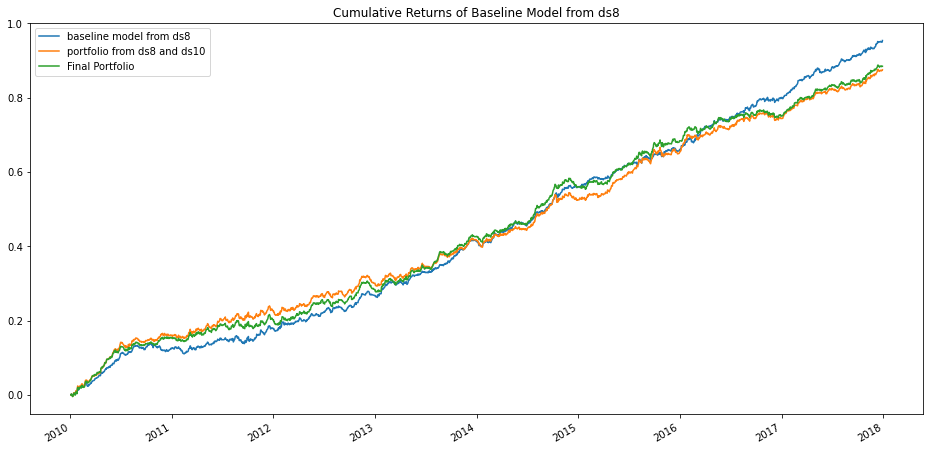

In [80]:
plt.figure(figsize=(16, 8))
(portfolio_8.shift(2)[univ == 1].fillna(0) * ret1).sum(1).cumsum().plot(label='baseline model from ds8')
(portfolio_8_10.shift(2)[univ == 1].fillna(0) * ret1).sum(1).cumsum().plot(label='portfolio from ds8 and ds10')
(new_portfolio.shift(2)[univ == 1].fillna(0) * ret1).sum(1).cumsum().plot(label='Final Portfolio')
plt.legend()
# plt.grid()
plt.title('Cumulative Returns of Baseline Model from ds8')

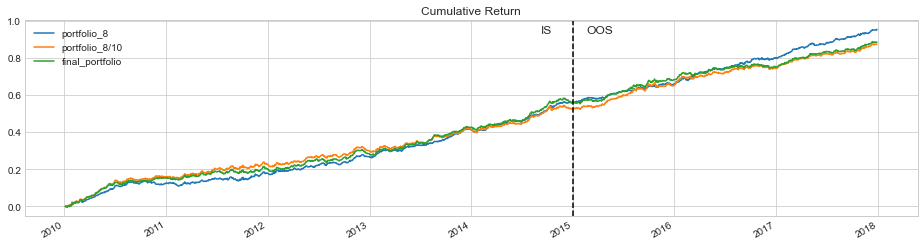

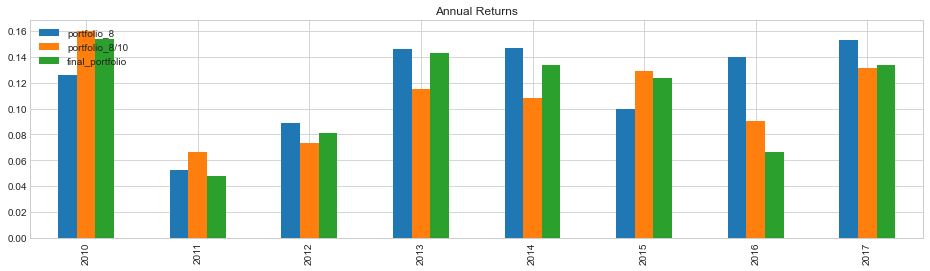

In [84]:
plot_pnl(pd.DataFrame({k: (v * ret1).sum(1)  for k, v in all_portfolio.items()}), cutoff_dt=CUTOFF_DT)

In [82]:
stats, cum_ret, DrawDown_res = PNL_analysis(all_portfolio, 
                                            ret1, cutoff_dt=CUTOFF_DT,
                 nDaysYear=252, cost=0, nlargest_DD=1, detail_analysis=True)
display_stats(stats)

,Sharpe,IS Sharpe,OOS Sharpe,Daily TO(%),annualized_returns(%),annualized_volatility(%),positive_dates(%)
portfolio_8,3.47,3.30,3.76,8.74,11.95,3.44,56.48
portfolio_8/10,2.72,2.60,2.91,6.76,10.96,4.04,54.00
final_portfolio,2.73,2.76,2.67,8.86,11.08,4.06,52.96
